# Water Scarcity and Global Conflict Analysis
This project aims to explore the complex relationship between armed conflict and water scarcity by integrating and analyzing datasets from various sources. We will leverage geospatial and environmental data to assess how water scarcity influences the occurrence and intensity of confict

## Project Summary

### Hypothesis: 
Water is one of the most critical resources on the planet for human survival. When the demand for critical resources, such as water, exceeds the supply, the number of conflicts increases.

### Questions:
- How does water scarcity correlate with the frequency and intensity of armed conflicts?
- What are the geographical patterns of conflict relative to water scarcity?
- Can changes in water availability predict increases in conflict events?
- Are certain types of conflicts more likely to occur in water-scarce regions?
- Are there other factors that affect the frequency of armed conflicts in water scarce areas?

### Data Sources
- Food and Agriculture Organization (FAO) https://data.apps.fao.org/aquastat/?lang=en
- University of Alabama https://internationalconflict.ua.edu/data-download/
- Correlates of War (COW) https://correlatesofwar.org/data-sets/cow-country-codes.csv
- World Bank Group's Data Bank https://databank.worldbank.org/reportsup.html

## Question 1 - How does water scarcity correlate with the frequency and intensity of armed conflicts?

In [72]:
# Import Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from scipy.stats import stats
from scipy.stats import pearsonr
from functools import partial, reduce

In [3]:
# Load the datasets
aqua_csv = pd.read_csv('Resources/AQUASTAT Dissemination System.csv') # FAO Aquastat Data
mie_csv = pd.read_csv('Resources/ua-mie-1.0.csv') # University of Alabama International Conflict Data
cow_country_codes = pd.read_csv('Resources/COW-country-codes.csv')
micnames = pd.read_csv('Resources/ua-micnames-1.0.csv')
WDI_df = pd.read_csv('Resources/WDI_World.csv')

In [4]:
code_to_country = pd.Series(cow_country_codes.StateNme.values, index=cow_country_codes.CCode).to_dict()

In [5]:
mie_csv['ccode1'] = mie_csv['ccode1'].map(code_to_country)
mie_csv['ccode2'] = mie_csv['ccode2'].map(code_to_country)
mie_csv.head()

,micnum,eventnum,ccode1,ccode2,stmon,stday,styear,endmon,endday,endyear,sidea1,action,hostlev,fatalmin1,fatalmax1,fatalmin2,fatalmax2,version
0,2,1,United States of America,United Kingdom,5,-9,1902,5,-9,1902,1,7,3,0,0,0,0,mie-1.0
1,3,1,Austria-Hungary,Yugoslavia,10,7,1913,10,7,1913,1,1,2,0,0,0,0,mie-1.0
2,4,2,Albania,United Kingdom,5,15,1946,5,15,1946,1,16,4,0,0,0,0,mie-1.0
3,4,3,United Kingdom,Albania,10,22,1946,10,22,1946,0,7,3,0,0,0,0,mie-1.0
4,4,4,United Kingdom,Albania,10,22,1946,10,22,1946,0,7,3,0,0,0,0,mie-1.0


In [6]:
mie_csv = mie_csv.rename(columns={'ccode1': 'Country'})
mie_csv = mie_csv.rename(columns={'ccode2': 'Target Country'})
aqua_csv = aqua_csv.rename(columns={'Area': 'Country'})
COW_Country_Codes = cow_country_codes.rename(columns={'StateNme':'Country'})
mie_csv = mie_csv.rename(columns={'styear': 'Year'})

In [7]:
# conflict_name = pd.Series(micnames.micname.values, index= micnames.micnum).to_dict()

In [8]:
# mie_csv['micnum'] = mie_csv['micnum'].map(conflict_name)
mie_df = pd.DataFrame(mie_csv)
mie_df

,micnum,eventnum,Country,Target Country,stmon,stday,Year,endmon,endday,endyear,sidea1,action,hostlev,fatalmin1,fatalmax1,fatalmin2,fatalmax2,version
0,2,1,United States of America,United Kingdom,5,-9,1902,5,-9,1902,1,7,3,0,0,0,0,mie-1.0
1,3,1,Austria-Hungary,Yugoslavia,10,7,1913,10,7,1913,1,1,2,0,0,0,0,mie-1.0
2,4,2,Albania,United Kingdom,5,15,1946,5,15,1946,1,16,4,0,0,0,0,mie-1.0
3,4,3,United Kingdom,Albania,10,22,1946,10,22,1946,0,7,3,0,0,0,0,mie-1.0
4,4,4,United Kingdom,Albania,10,22,1946,10,22,1946,0,7,3,0,0,0,0,mie-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28006,9946,1,Peru,Ecuador,10,4,1859,10,4,1859,1,7,3,0,0,0,0,mie-1.0
28007,9946,2,Peru,Ecuador,11,8,1859,1,25,1860,1,14,4,0,0,0,0,mie-1.0
28008,9947,1,Cambodia,Vietnam,5,-9,1975,5,-9,1975,1,17,4,0,0,0,0,mie-1.0
28009,9947,2,Vietnam,Cambodia,6,10,1975,12,7,1975,0,14,4,0,0,0,0,mie-1.0


In [9]:
# Filter for years between 1980 and 2015
filtered_year_df = mie_df[(mie_df['Year'] >= 1980) & (mie_df['Year'] <= 2015)]

# If you want to filter for specific countries, e.g., 'USA' and 'Canada'
countries = mie_df['Country']
filtered_df = filtered_year_df[filtered_year_df['Country'].isin(countries)]

# Group by 'Year' and count unique 'micnum' for each year
mie_per_year_df = filtered_df.groupby(['Year', 'Country'])['micnum'].nunique().reset_index()

# Rename columns for clarity
mie_per_year_df.columns = ['Year', 'Country', 'Number_of_Conflicts']

# Display the result
mie_per_year_df.head(10)

,Year,Country,Number_of_Conflicts
0,1980,Afghanistan,1
1,1980,Angola,1
2,1980,Argentina,1
3,1980,Canada,1
4,1980,Chile,1
5,1980,Colombia,1
6,1980,Cuba,2
7,1980,Democratic Republic of the Congo,1
8,1980,Egypt,1
9,1980,Ethiopia,1


In [10]:
total_conflicts_per_year_df = mie_per_year_df.groupby('Year')['Number_of_Conflicts'].sum().reset_index()

# Rename columns for clarity
total_conflicts_per_year_df.columns = ['Year', 'Total_Conflicts']

# Display the result
print("Total Conflicts per Year:\n", total_conflicts_per_year_df)

Total Conflicts per Year:
     Year  Total_Conflicts
0   1980               57
1   1981               51
2   1982               51
3   1983               69
4   1984               67
5   1985               54
6   1986               53
7   1987               66
8   1988               30
9   1989               28
10  1990               17
11  1991               32
12  1992               44
13  1993               79
14  1994               66
15  1995               68
16  1996               64
17  1997               64
18  1998               78
19  1999               87
20  2000               60
21  2001               74
22  2002               70
23  2003               73
24  2004               49
25  2005               58
26  2006               41
27  2007               35
28  2008               39
29  2009               32
30  2010               37
31  2011               97
32  2012               60
33  2013               70
34  2014               75


In [11]:
no_of_countries_by_year_df = filtered_df.groupby('Year')['Country'].nunique().reset_index()

no_of_countries_by_year_df.columns = ['Year', 'Number_of_Countries_in_Conflict']

no_of_countries_by_year_df

,Year,Number_of_Countries_in_Conflict
0,1980,41
1,1981,35
2,1982,36
3,1983,43
4,1984,44
5,1985,35
6,1986,33
7,1987,40
8,1988,20
9,1989,23


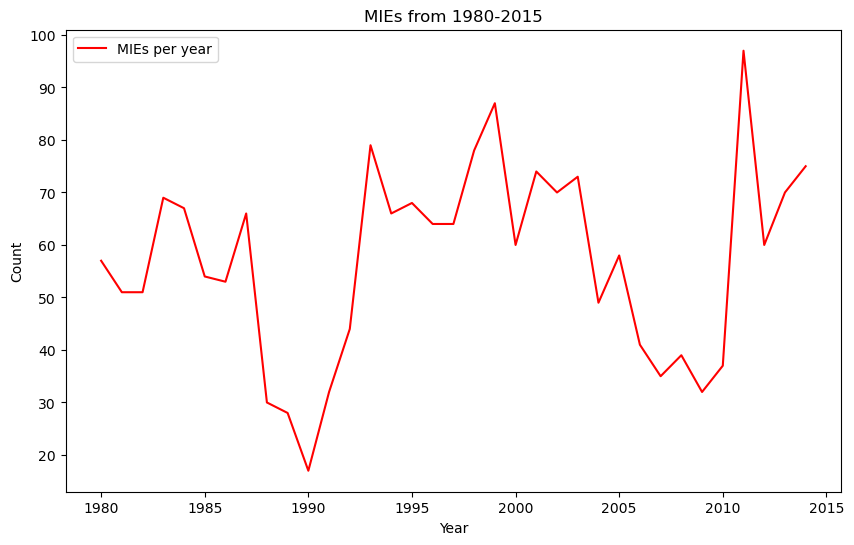

In [12]:
# Plot conflicts between 1980-2015  - NOT USED IN PRESENTATION
plt.figure(figsize=(10, 6))
sns.lineplot(data=total_conflicts_per_year_df, x='Year', y='Total_Conflicts', label='MIEs per year', color="red")
plt.title('MIEs from 1980-2015')
plt.xlabel('Year')
plt.ylabel('Count') 
plt.legend()
plt.show()

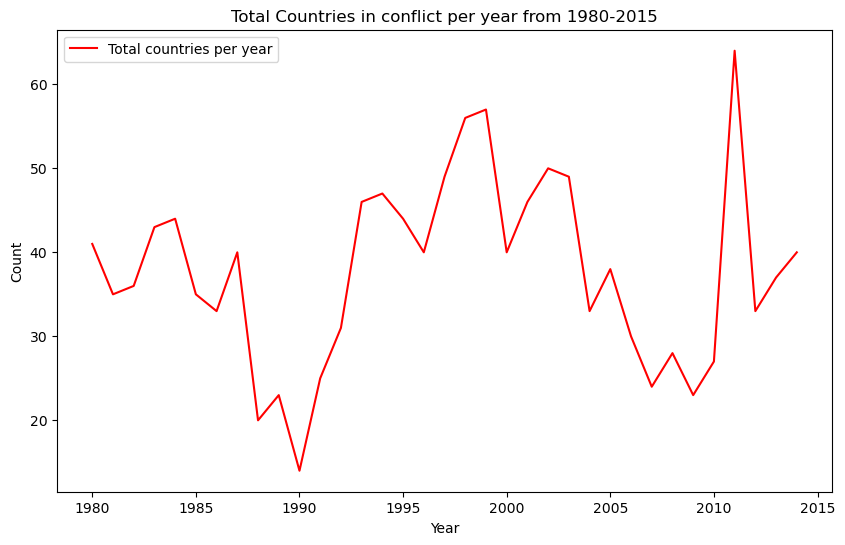

In [13]:
# Plot total countries in conflit per year between 1980-2015  - NOT USED IN PRESENTATION
plt.figure(figsize=(10, 6))
sns.lineplot(data=no_of_countries_by_year_df, x='Year', y='Number_of_Countries_in_Conflict', label='Total countries per year', color="red")
plt.title('Total Countries in conflict per year from 1980-2015')
plt.xlabel('Year')
plt.ylabel('Count') 
plt.legend()
plt.show()

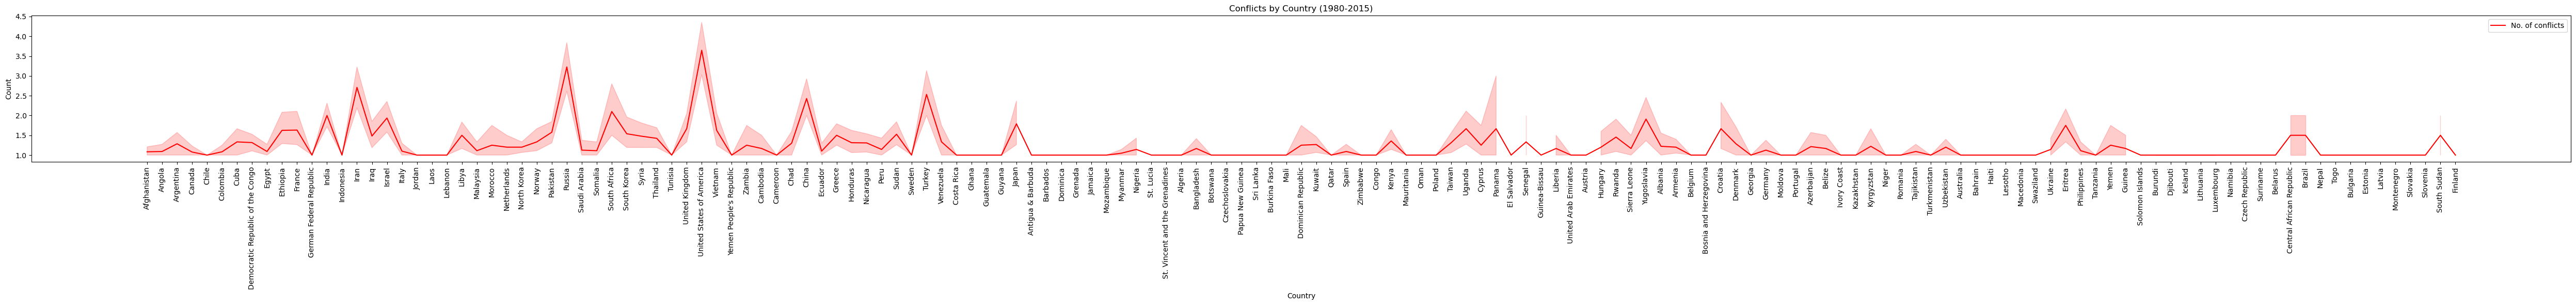

In [14]:
# Plot conflicts by country between 1980-2015  - NOT USED IN PRESENTATION
plt.figure(figsize=(50, 6))
sns.lineplot(data=mie_per_year_df, x='Country', y='Number_of_Conflicts', label='No. of conflicts', color="red")
plt.title('Conflicts by Country (1980-2015)')
plt.xlabel('Country')
plt.ylabel('Count') 
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
# Filter water stress data to include only the specific variable
water_df = pd.DataFrame(aqua_csv)
keyword = 'SDG 6.4.2. Water Stress'
filtered_water = aqua_csv['Variable'].str.contains(keyword, na=False)
filtered_water_df = water_df[filtered_water]
filtered_water_df.head()

,VariableGroup,Subgroup,Variable,Country,Year,Value,Unit,Symbol,IsAggregate
28609,Water use,Pressure on water resources,SDG 6.4.2. Water Stress,Afghanistan,1981,49.69101,%,E,False
28610,Water use,Pressure on water resources,SDG 6.4.2. Water Stress,Afghanistan,1982,53.15823,%,E,False
28611,Water use,Pressure on water resources,SDG 6.4.2. Water Stress,Afghanistan,1983,56.62545,%,E,False
28612,Water use,Pressure on water resources,SDG 6.4.2. Water Stress,Afghanistan,1984,60.09267,%,E,False
28613,Water use,Pressure on water resources,SDG 6.4.2. Water Stress,Afghanistan,1985,63.55989,%,E,False


In [19]:
water_columns_to_drop = ['VariableGroup', 'Subgroup', 'Variable', 'Unit', 'Symbol', 'IsAggregate']
existing_water_columns_to_drop = [col for col in water_columns_to_drop if col in filtered_water_df.columns]

if existing_water_columns_to_drop:
   filtered_water_df = filtered_water_df.drop(columns=existing_water_columns_to_drop)
else:
    print("No columns to drop.")

In [20]:
filtered_water_df.head()

,Country,Year,Value
28609,Afghanistan,1981,49.69101
28610,Afghanistan,1982,53.15823
28611,Afghanistan,1983,56.62545
28612,Afghanistan,1984,60.09267
28613,Afghanistan,1985,63.55989


In [21]:
filtered_water_by_year_df = filtered_water_df[(filtered_water_df['Year'] >= 1980) & (filtered_water_df['Year'] <= 2015)]

In [81]:
#Groupby year and value
overall_percentage_per_year_df = pd.DataFrame(filtered_water_by_year_df.groupby('Year')['Value'].mean().reset_index())
overall_percentage_per_year_df

,Year,Value
0,1981,57.192850
1,1982,59.129871
2,1983,62.086189
3,1984,64.124653
4,1985,61.485680
5,1986,62.858329
6,1987,46.081684
7,1988,47.134030
8,1989,48.748405
9,1990,47.181621


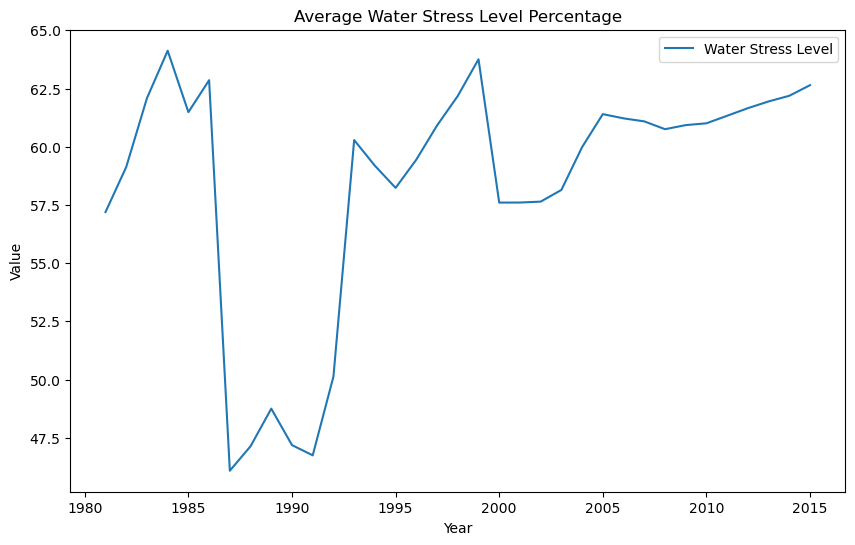

In [82]:
# Total Water Stress Level by year by average  - NOT USED IN PRESENTATION
plt.figure(figsize=(10, 6))
sns.lineplot(data=overall_percentage_per_year_df, x='Year', y='Value', label='Water Stress Level')
plt.title('Average Water Stress Level Percentage')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()

In [83]:
total_value_per_year = filtered_water_by_year_df.groupby('Year')['Value'].sum().reset_index()
print(total_value_per_year)

    Year         Value
0   1981   3088.413899
1   1982   3252.142902
2   1983   3414.740393
3   1984   3590.980563
4   1985   3750.626476
5   1986   3897.216413
6   1987   4101.269832
7   1988   4242.062680
8   1989   4387.356432
9   1990   4812.525321
10  1991   5048.127703
11  1992   6015.219326
12  1993   7777.031245
13  1994   7989.895941
14  1995   8210.882544
15  1996   8501.067554
16  1997   8771.495860
17  1998   9016.365135
18  1999   9308.500182
19  2000  10195.361808
20  2001  10310.827281
21  2002  10490.792892
22  2003  10640.352761
23  2004  11037.277393
24  2005  11420.581346
25  2006  11570.399467
26  2007  11668.110933
27  2008  11786.280595
28  2009  11820.190836
29  2010  11896.321054
30  2011  11959.531257
31  2012  12269.738402
32  2013  12327.251789
33  2014  12375.695695
34  2015  12466.532545


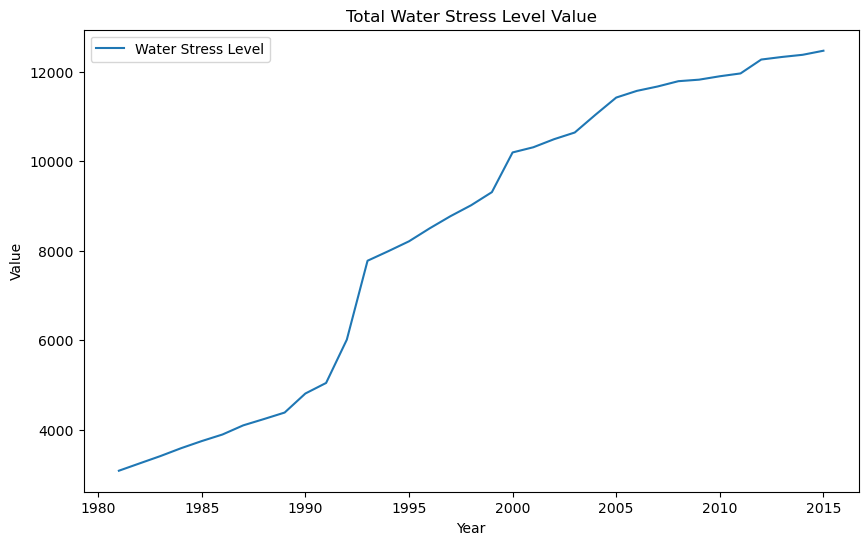

In [84]:
# Total Water Stress Level by year by sum  - NOT USED IN PRESENTATION
plt.figure(figsize=(10, 6))
sns.lineplot(data=total_value_per_year, x='Year', y='Value', label='Water Stress Level')
plt.title('Total Water Stress Level Value')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()

In [85]:
#Further filter water data by country and count total water stress per country between years 1980-2015
water_country_counts = filtered_water_by_year_df['Country'].value_counts().sort_index()
water_stress_per_country_df = pd.DataFrame({'Country': water_country_counts.index, 'Count': water_country_counts.values})
water_stress_per_country_df

,Country,Count
0,Afghanistan,35
1,Albania,26
2,Algeria,35
3,Angola,29
4,Antigua and Barbuda,26
...,...,...
194,Western Asia,16
195,World,16
196,Yemen,26
197,Zambia,24


In [86]:
overall_percentage_per_country_df = pd.DataFrame(filtered_water_by_year_df.groupby('Country')['Value'].mean().reset_index())
overall_percentage_per_country_df

,Country,Value
0,Afghanistan,58.071436
1,Albania,7.921158
2,Algeria,78.626706
3,Angola,1.673621
4,Antigua and Barbuda,7.433432
...,...,...
194,Western Asia,59.696875
195,World,17.894375
196,Yemen,160.847985
197,Zambia,2.905581


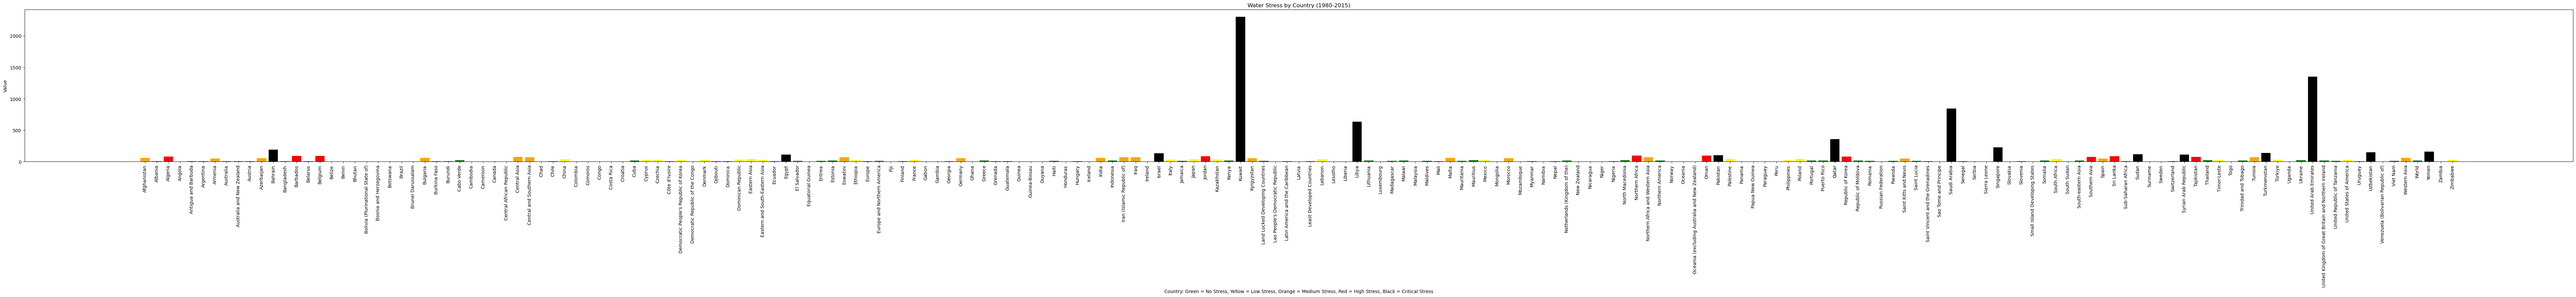

In [87]:
# Define conditions and corresponding colors   - NOT USED IN PRESENTATION
conditions = [
    (overall_percentage_per_country_df['Value'] <= 25),
    (overall_percentage_per_country_df['Value'] > 25) & (overall_percentage_per_country_df['Value'] <= 50),
    (overall_percentage_per_country_df['Value'] > 50) & (overall_percentage_per_country_df['Value'] <= 75),
    (overall_percentage_per_country_df['Value'] > 75) & (overall_percentage_per_country_df['Value'] <= 100)
]
colors = ['green', 'yellow', 'orange', 'red']

# Use np.select to assign colors based on conditions
overall_percentage_per_country_df['Color'] = np.select(conditions, colors, default='black')

# Plotting
fig, ax = plt.subplots(figsize=(100, 6))

# Plot bars manually
bars = ax.bar(overall_percentage_per_country_df['Country'], overall_percentage_per_country_df['Value'], color=overall_percentage_per_country_df['Color'])

# Add titles and labels
ax.set_title('Water Stress by Country (1980-2015)')
ax.set_xlabel('Country: Green = No Stress, Yellow = Low Stress, Orange = Medium Stress, Red = High Stress, Black = Critical Stress')
ax.set_ylabel('Value')
ax.tick_params(axis='x', labelrotation=90)

plt.show()

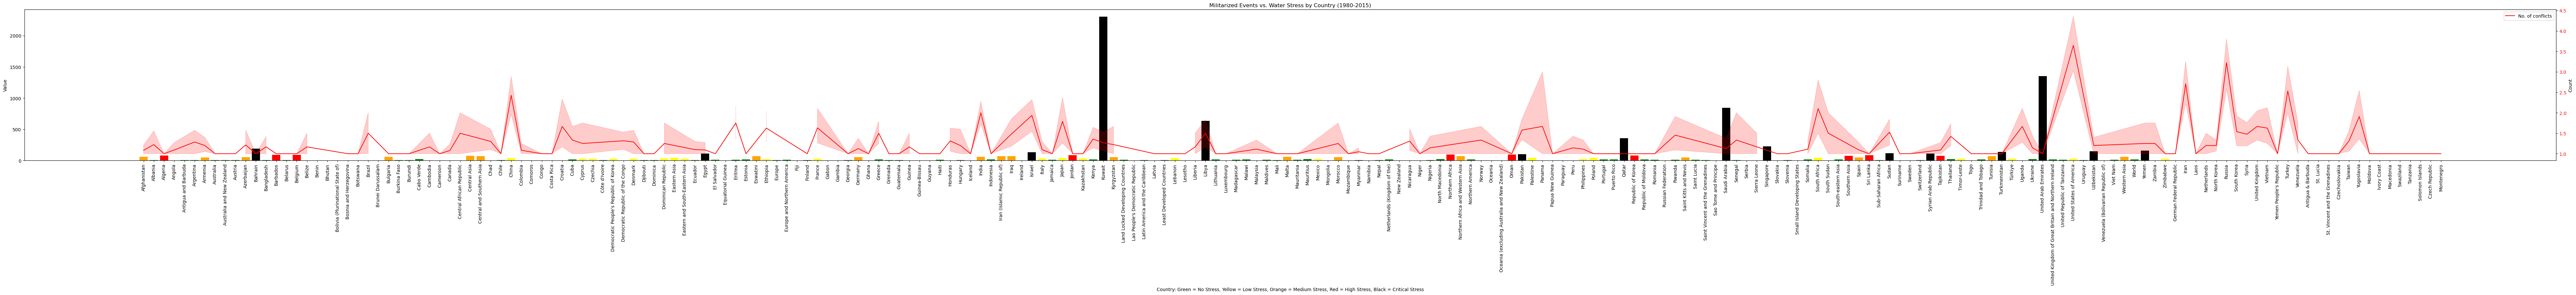

In [29]:
# Define conditions and corresponding colors  - NOT USED IN PRESENTATION
conditions = [
    (overall_percentage_per_country_df['Value'] <= 25),
    (overall_percentage_per_country_df['Value'] > 25) & (overall_percentage_per_country_df['Value'] <= 50),
    (overall_percentage_per_country_df['Value'] > 50) & (overall_percentage_per_country_df['Value'] <= 75),
    (overall_percentage_per_country_df['Value'] > 75) & (overall_percentage_per_country_df['Value'] <= 100)
]
colors = ['green', 'yellow', 'orange', 'red']

# Use np.select to assign colors based on conditions
overall_percentage_per_country_df['Color'] = np.select(conditions, colors, default='black')

# Plotting
fig, ax = plt.subplots(figsize=(100, 6))

# Plot bars manually
bars = ax.bar(overall_percentage_per_country_df['Country'], overall_percentage_per_country_df['Value'], color=overall_percentage_per_country_df['Color'])

# Add titles and labels
ax.set_title('Militarized Events vs. Water Stress by Country (1980-2015)')
ax.set_xlabel('Country: Green = No Stress, Yellow = Low Stress, Orange = Medium Stress, Red = High Stress, Black = Critical Stress')
ax.set_ylabel('Value')
ax.tick_params(axis='x', labelrotation=90)

ax2 = ax.twinx()

sns.lineplot(data=mie_per_year_df, x='Country', y='Number_of_Conflicts', label='No. of conflicts', color="red")
ax2.set_xlabel('Country')
ax2.set_ylabel('Count')
ax2.tick_params(axis='y', labelcolor='red')
ax2.tick_params(axis='x', labelrotation=90)

plt.savefig('militarized_events_vs_water_stress_by_country.png_color_coded.png', bbox_inches='tight') 
plt.show()

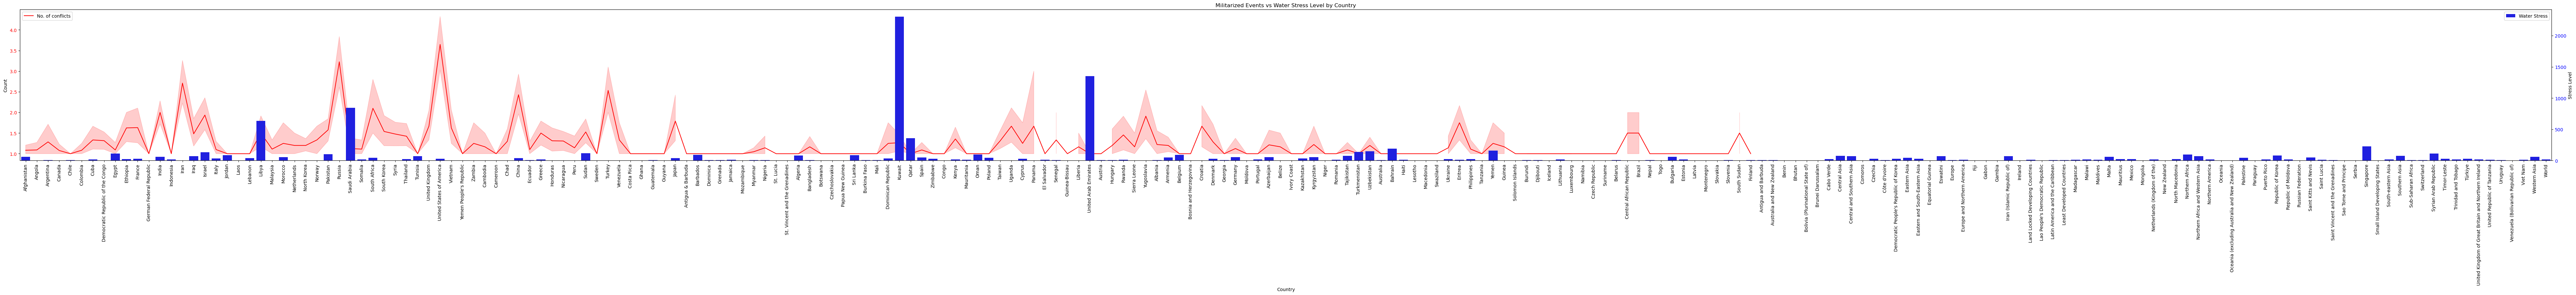

In [30]:
#  - NOT USED IN PRESENTATION
fig, ax1 = plt.subplots(figsize=(100, 6))
sns.lineplot(data=mie_per_year_df, x='Country', y='Number_of_Conflicts', label='No. of conflicts', color="red")
ax1.set_xlabel('Country')
ax1.set_ylabel('Count')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()

sns.barplot(data=overall_percentage_per_country_df, x='Country', y='Value', label='Water Stress', color="blue")
plt.xlabel('Country')
ax2.set_ylabel('Stress Level')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.set_title('Militarized Events vs Water Stress Level by Country')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax1.tick_params(axis='x', labelrotation=90)

plt.savefig('militarized_events_vs_water_stress_by_country.png', bbox_inches='tight') 
plt.show()

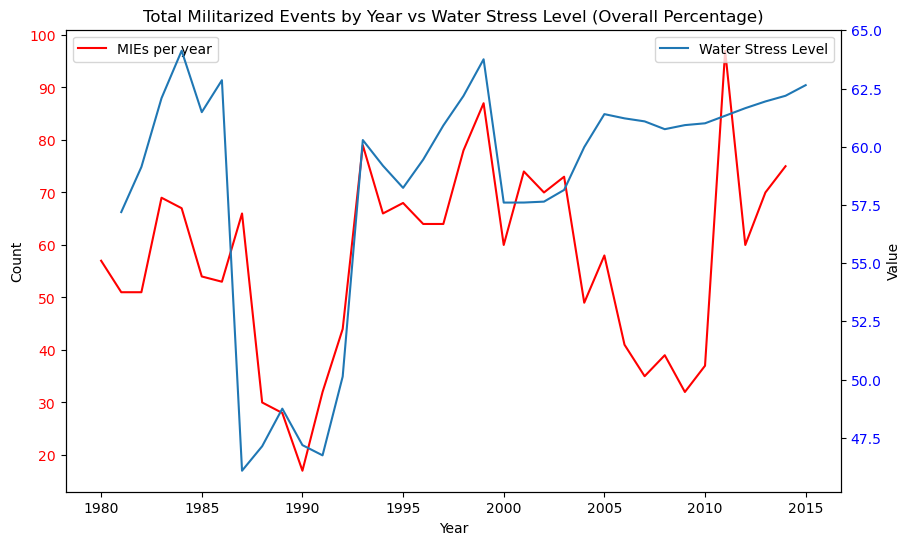

In [88]:
#Total Militarized Events by Year vs Water Stress Level (Overall Percentage) - USED ON SLIDE 2
fig, ax1 = plt.subplots(figsize=(10, 6))

sns.lineplot(data=total_conflicts_per_year_df, x='Year', y='Total_Conflicts', label='MIEs per year', color="red")
plt.title('MIEs from 1980-2015')
ax1.set_xlabel('Year')
ax1.set_ylabel('Count') 
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()

sns.lineplot(data=overall_percentage_per_year_df, x='Year', y='Value', label='Water Stress Level')
plt.xlabel('Year')
ax2.set_ylabel('Value')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.set_title('Total Militarized Events by Year vs Water Stress Level (Overall Percentage)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.savefig('militarized_events_vs_water_stress_by_year.png', bbox_inches='tight') 
plt.show()

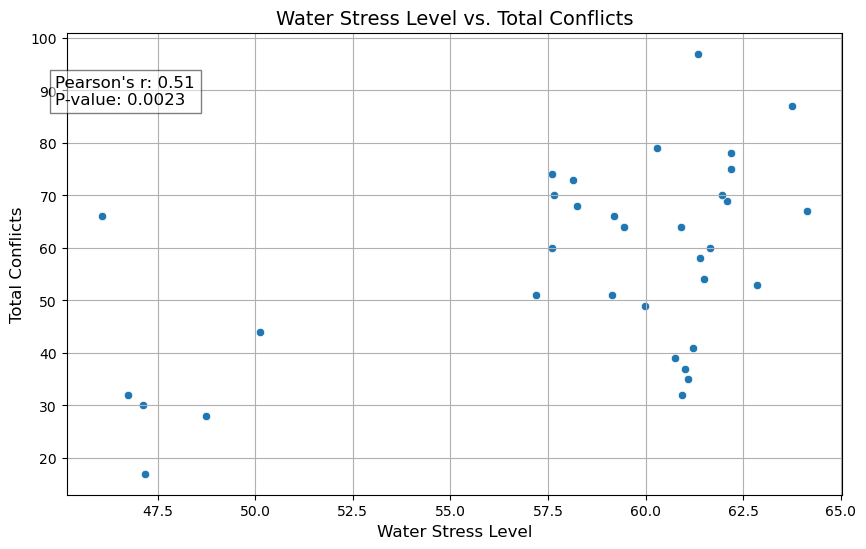

In [98]:
# Correlation between Total Militarized Events by Year vs Water Stress Level (Overall Percentage)
# Align the datasets on the same years
mie_water_stress_merged_df = overall_percentage_per_year_df.merge(total_conflicts_per_year_df, on='Year')
water_stress_values = mie_water_stress_merged_df['Value']
total_conflicts_values = mie_water_stress_merged_df['Total_Conflicts']

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=water_stress_values, y=total_conflicts_values)

# Customizing the scatter plot
plt.title('Water Stress Level vs. Total Conflicts', fontsize=14)
plt.xlabel('Water Stress Level', fontsize=12)
plt.ylabel('Total Conflicts', fontsize=12)
plt.grid(True)

# Calculate Pearson's r
correlation_coefficient, p_value = pearsonr(water_stress_values, total_conflicts_values)

# Display Pearson's r and p-value on the plot
plt.text(x=max(water_stress_values)*0.7, y=max(total_conflicts_values)*0.9,
         s=f"Pearson's r: {correlation_coefficient:.2f}\nP-value: {p_value:.4f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Save the scatter plot and p value calculation
plt.savefig('water_stress_total_conflicts_p_value.png', bbox_inches='tight') 
# Display the plot
plt.show()

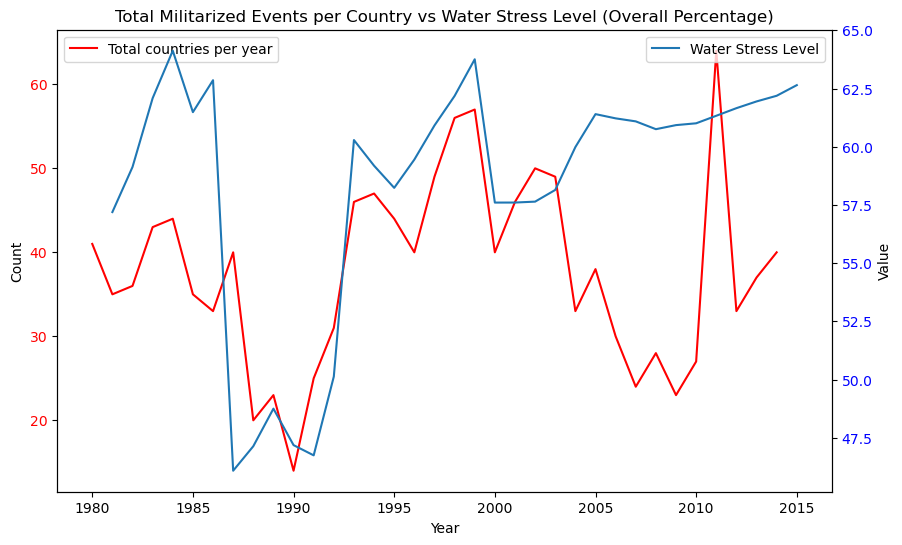

In [32]:
#Total Militarized Events per Country vs Water Stress Level (Overall Percentage)  - USED ON SLIDE 2
fig, ax1 = plt.subplots(figsize=(10, 6))

sns.lineplot(data=no_of_countries_by_year_df, x='Year', y='Number_of_Countries_in_Conflict', label='Total countries per year', color="red")
plt.title('Total Countries in conflict per year from 1980-2015')
ax1.set_xlabel('Year')
ax1.set_ylabel('Count') 
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()

sns.lineplot(data=overall_percentage_per_year, x='Year', y='Value', label='Water Stress Level')
plt.xlabel('Year')
ax2.set_ylabel('Value')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.set_title('Total Militarized Events per Country vs Water Stress Level (Overall Percentage)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.savefig('militarized_events_vs_water_stress_by_country.png', bbox_inches='tight') 
plt.show()


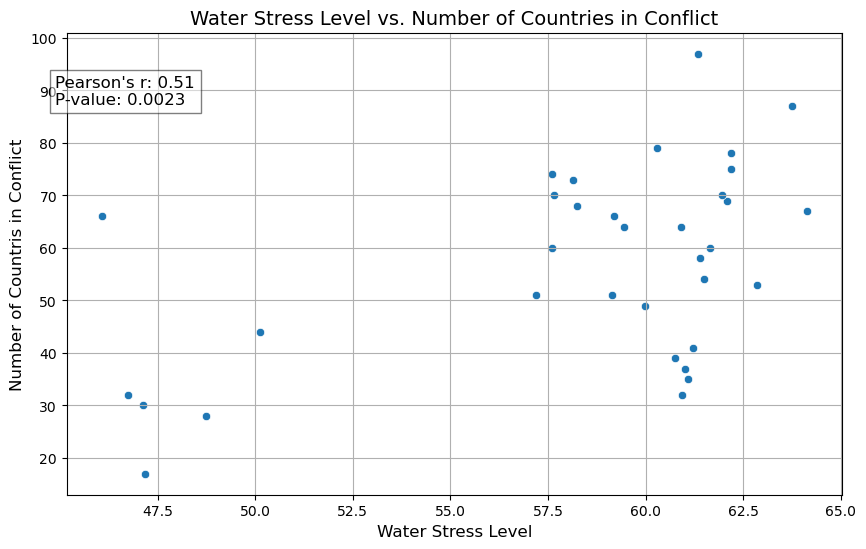

In [99]:
# Correlation between Total Militarized Events per Country by Year vs Water Stress Level (Overall Percentage)
# Align the datasets on the same years
mie_water_stress_country_merged_df = overall_percentage_per_year_df.merge(no_of_countries_by_year_df, on='Year')
water_stress_values = mie_water_stress_country_merged_df['Value']
country_values = mie_water_stress_country_merged_df['Number_of_Countries_in_Conflict']

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=water_stress_values, y=total_conflicts_values)

# Customizing the scatter plot
plt.title('Water Stress Level vs. Number of Countries in Conflict', fontsize=14)
plt.xlabel('Water Stress Level', fontsize=12)
plt.ylabel('Number of Countris in Conflict', fontsize=12)
plt.grid(True)

# Calculate Pearson's r
correlation_coefficient, p_value = pearsonr(water_stress_values, total_conflicts_values)

# Display Pearson's r and p-value on the plot
plt.text(x=max(water_stress_values)*0.7, y=max(total_conflicts_values)*0.9,
         s=f"Pearson's r: {correlation_coefficient:.2f}\nP-value: {p_value:.4f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Save the scatter plot and p value calculation
plt.savefig('water_stress_total_conflicts_by_country_p_value.png', bbox_inches='tight') 
# Display the plot
plt.show()

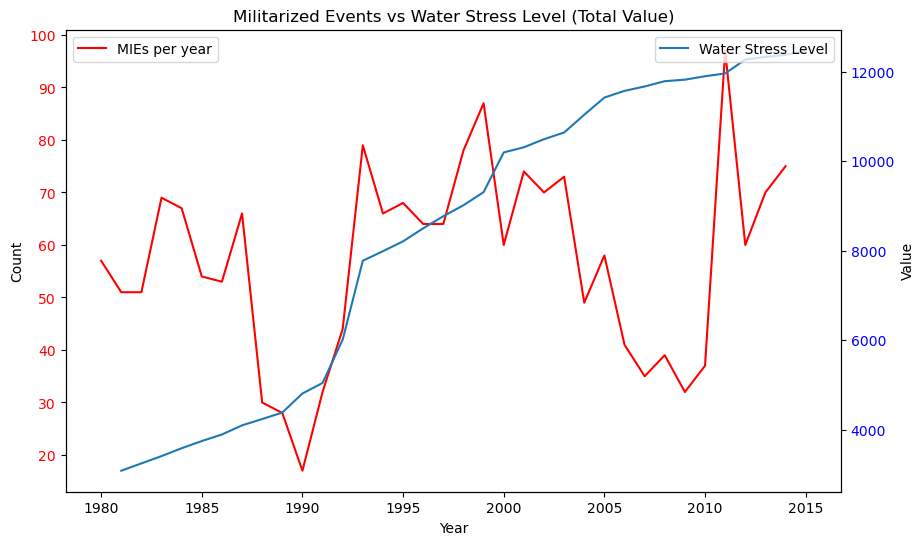

In [33]:
#Militarized Events vs Water Stress Level (Total Value) - NOT USED
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.lineplot(data=total_conflicts_per_year_df, x='Year', y='Total_Conflicts', label='MIEs per year', color="red")
plt.title('MIEs from 1980-2015')
ax1.set_xlabel('Year')
ax1.set_ylabel('Count') 
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()

sns.lineplot(data=total_value_per_year, x='Year', y='Value', label='Water Stress Level')
plt.xlabel('Year')
ax2.set_ylabel('Value')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.set_title('Militarized Events vs Water Stress Level (Total Value)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.savefig('militarized_events_vs_water_stress_by_year(total_value).png', bbox_inches='tight') 
plt.show()

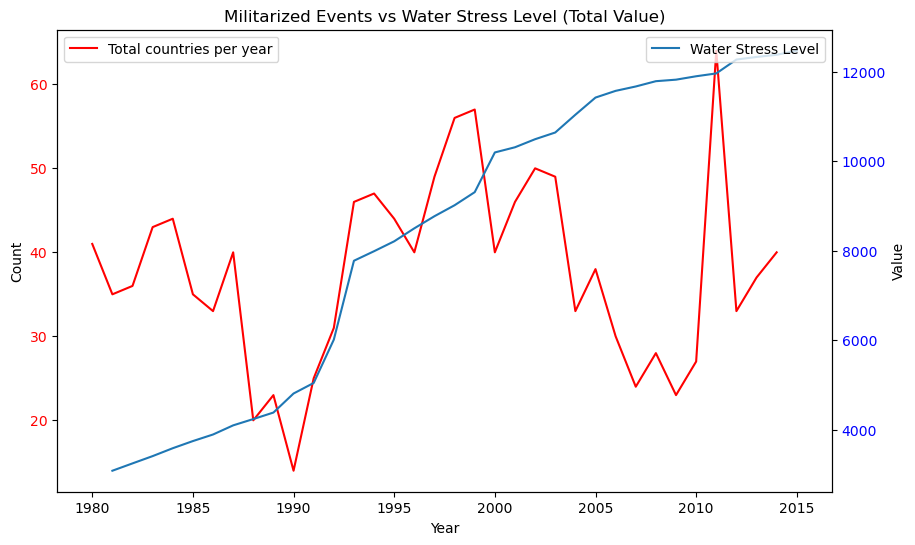

In [34]:
#Militarized Events vs Water Stress Level (Total Value) - NOT USED
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.lineplot(data=no_of_countries_by_year_df, x='Year', y='Number_of_Countries_in_Conflict', label='Total countries per year', color="red")
plt.title('Total Countries in conflict per year from 1980-2015')
ax1.set_xlabel('Year')
ax1.set_ylabel('Count') 
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()

sns.lineplot(data=total_value_per_year, x='Year', y='Value', label='Water Stress Level')
plt.xlabel('Year')
ax2.set_ylabel('Value')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.set_title('Militarized Events vs Water Stress Level (Total Value)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.savefig('militarized_events_vs_water_stress_by_year(total_value).png', bbox_inches='tight') 
plt.show()

In [35]:
WDI_df.head()

,Country Name,Country Code,Series Name,Series Code,1980 [YR1980],1981 [YR1981],1982 [YR1982],1983 [YR1983],1984 [YR1984],1985 [YR1985],...,2006 [YR2006],2007 [YR2007],2008 [YR2008],2009 [YR2009],2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015]
0,World,WLD,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,75.6029242323162,75.6959573806835,76.8422110237843,76.5974772799729,76.6024728497366,76.0495676429734,...,51.8801297987834,51.8911235516106,52.966802416295,51.9946192893429,52.0244359748872,51.6598102561403,51.434801818807,51.2004449275282,50.8094847365935,47.1934417463395
1,World,WLD,"Agriculture, forestry, and fishing, value adde...",NV.AGR.TOTL.ZS,..,7.0910700563557,7.16024597566327,7.00093699145194,6.87155631154786,6.6958143602211,...,3.17072353955477,3.34625038441823,3.51161492194638,3.62617466845568,3.83079042429474,3.97244074140658,4.00944164694051,4.14482511964403,4.12759739539601,4.21044204006536
2,World,WLD,"Annual freshwater withdrawals, total (% of int...",ER.H2O.FWTL.ZS,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,8.99785000063423,9.00101020530396
3,World,WLD,Births attended by skilled health staff (% of ...,SH.STA.BRTC.ZS,..,..,..,..,..,..,...,..,..,..,..,69.7497316936597,..,..,..,..,..
4,World,WLD,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,..,..,..,..,..,..,...,4.41709984339302,4.52826428575511,4.50380815254763,4.3914854392157,4.60492937876465,4.68950582813015,4.68534777048442,4.71956435074903,4.68223911436346,4.6014345417289


In [36]:
# Set the columns that should stay as identifiers
WDI_indexed_df = WDI_df.set_index(['Country Name', 'Country Code', 'Series Name', 'Series Code'])

# Stack the DataFrame to convert the columns into rows
WDI_stacked_df = WDI_indexed_df.stack().reset_index(name='Value')

# Rename columns
WDI_stacked_df.rename(columns={'level_4': 'Year'}, inplace=True)

# Extract the year from the 'Year' column
WDI_stacked_df['Year'] = WDI_stacked_df['Year'].str.extract(r'(\d{4})').astype(int)

# Display the reshaped DataFrame
WDI_stacked_df.head()

,Country Name,Country Code,Series Name,Series Code,Year,Value
0,World,WLD,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1980,75.6029242323162
1,World,WLD,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1981,75.6959573806835
2,World,WLD,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1982,76.8422110237843
3,World,WLD,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1983,76.5974772799729
4,World,WLD,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1984,76.6024728497366


In [37]:
# Filter to include only the specific variable
keyword = 'NY.GDP.MKTP.CD'
WDI_GDP = WDI_stacked_df['Series Code'].str.contains(keyword, case=False, na=False)
WDI_GDP_df = WDI_stacked_df[WDI_GDP]
WDI_GDP_df.head()

,Country Name,Country Code,Series Name,Series Code,Year,Value
504,World,WLD,GDP (current US$),NY.GDP.MKTP.CD,1980,11419164161217.7
505,World,WLD,GDP (current US$),NY.GDP.MKTP.CD,1981,11796482847017.7
506,World,WLD,GDP (current US$),NY.GDP.MKTP.CD,1982,11648085880486.3
507,World,WLD,GDP (current US$),NY.GDP.MKTP.CD,1983,11972210792643.6
508,World,WLD,GDP (current US$),NY.GDP.MKTP.CD,1984,12445989345469.1


In [38]:
WDI_GDP_columns_to_drop = ['Country Name', 'Country Code', 'Series Name', 'Series Code']
WDI_GDP_existing_columns_to_drop = [col for col in WDI_GDP_columns_to_drop if col in WDI_GDP_df.columns]

if WDI_GDP_existing_columns_to_drop:
   WDI_GDP_df = WDI_GDP_df.drop(columns=WDI_GDP_existing_columns_to_drop)
else:
    print("No columns to drop.")

In [39]:
print(WDI_GDP_df.dtypes)

Year      int32
Value    object
dtype: object


In [40]:
WDI_GDP_df['Value'] = WDI_GDP_df['Value'].astype(float)
print(WDI_GDP_df.dtypes)

Year       int32
Value    float64
dtype: object


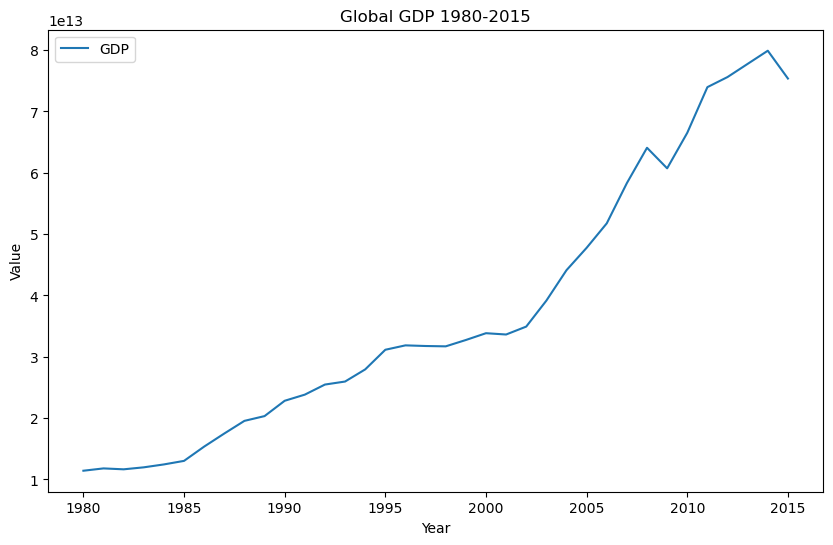

In [41]:
# Global GDP by year  - NOT USED IN PRESENTATION
plt.figure(figsize=(10, 6))
sns.lineplot(data=WDI_GDP_df, x='Year', y='Value', label='GDP')
plt.title('Global GDP 1980-2015')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()

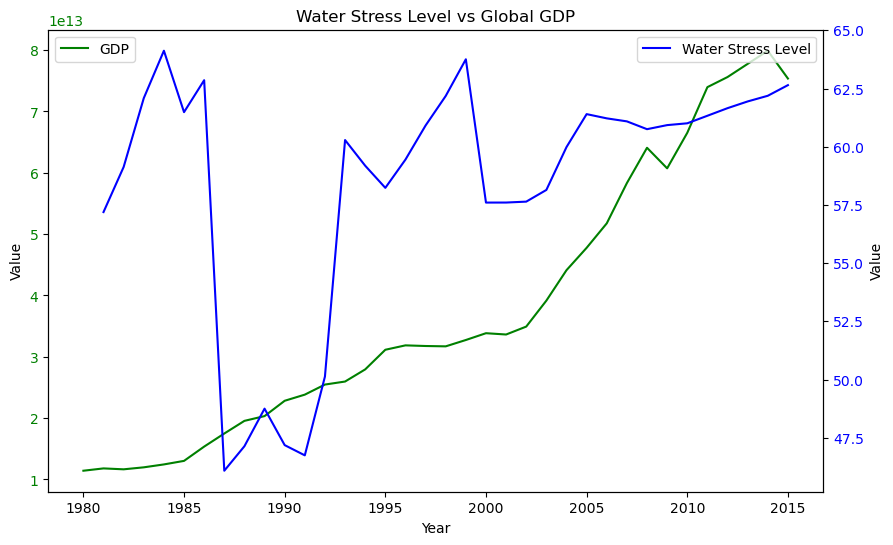

In [42]:
#Water Stress Level vs Global GDP - USED IN SLIDE 6
# Create figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Militarized Events
sns.lineplot(data=WDI_GDP_df, x='Year', y='Value', label='GDP', color='green')
ax1.set_xlabel('Year')
ax1.set_ylabel('Value')
ax1.tick_params(axis='y', labelcolor='green')

# Create twin axes for Water Stress Level
ax2 = ax1.twinx()
sns.lineplot(data=overall_percentage_per_year, x='Year', y='Value', label='Water Stress Level', color='blue', ax=ax2)
ax2.set_ylabel('Value')
ax2.tick_params(axis='y', labelcolor='blue')

# Add title
ax1.set_title('Water Stress Level vs Global GDP')

plt.savefig('water_stress_GDP.png', bbox_inches='tight') 
plt.show()

In [43]:
# Filter to include only the specific variable
keyword = 'EN.ATM.CO2E.PC'
WDI_CO2 = WDI_stacked_df['Series Code'].str.contains(keyword, case=False, na=False)
WDI_CO2_df = WDI_stacked_df[WDI_CO2]
WDI_CO2_df

,Country Name,Country Code,Series Name,Series Code,Year,Value
144,World,WLD,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,1980,..
145,World,WLD,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,1981,..
146,World,WLD,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,1982,..
147,World,WLD,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,1983,..
148,World,WLD,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,1984,..
149,World,WLD,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,1985,..
150,World,WLD,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,1986,..
151,World,WLD,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,1987,..
152,World,WLD,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,1988,..
153,World,WLD,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,1989,..


In [44]:
WDI_CO2_columns_to_drop = ['Country Name', 'Country Code', 'Series Name', 'Series Code']
WDI_CO2_existing_columns_to_drop = [col for col in WDI_CO2_columns_to_drop if col in WDI_CO2_df.columns]

if WDI_CO2_existing_columns_to_drop:
   WDI_CO2_df = WDI_CO2_df.drop(columns=WDI_CO2_existing_columns_to_drop)
else:
    print("No columns to drop.")

In [45]:
print(WDI_CO2_df.dtypes)

Year      int32
Value    object
dtype: object


In [46]:
WDI_CO2_df['Value'] = pd.to_numeric(WDI_CO2_df['Value'], errors='coerce')
print(WDI_CO2_df.dtypes)

Year       int32
Value    float64
dtype: object


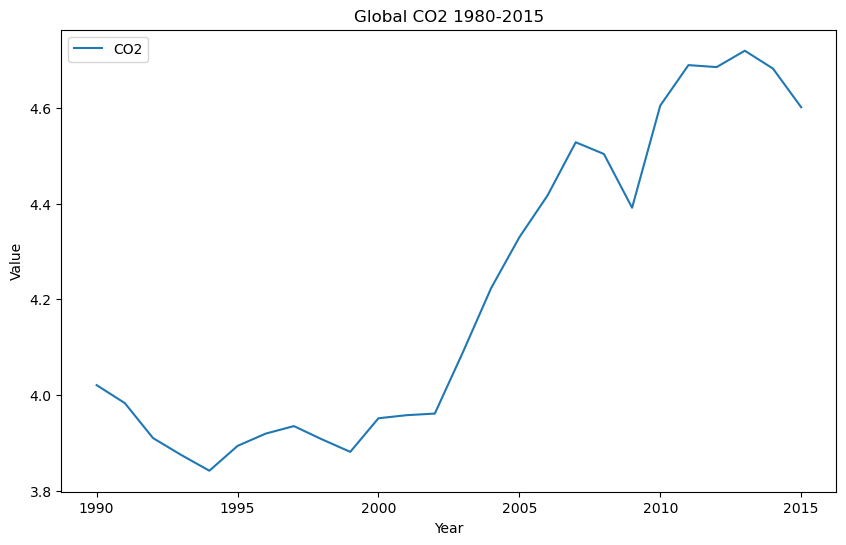

In [47]:
# Global CO2 by year  - NOT USED IN PRESENTATION
plt.figure(figsize=(10, 6))
sns.lineplot(data=WDI_CO2_df, x='Year', y='Value', label='CO2')
plt.title('Global CO2 1980-2015')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()

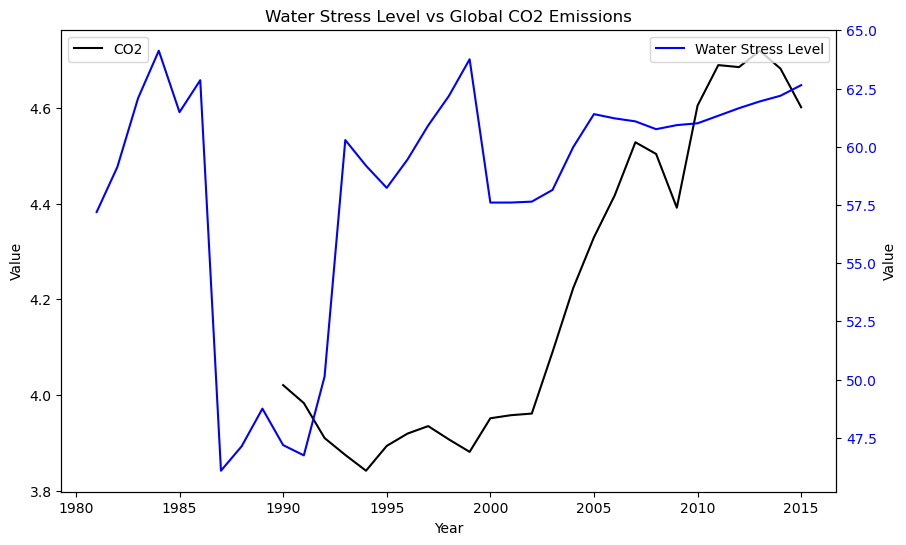

In [48]:
#Combined Water Stress and CO2 Chart - USED IN SLIDE 6
# Create figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Militarized Events
sns.lineplot(data=WDI_CO2_df, x='Year', y='Value', label='CO2', color='black')
ax1.set_xlabel('Year')
ax1.set_ylabel('Value')
ax1.tick_params(axis='y', labelcolor='black')

# Create twin axes for Water Stress Level
ax2 = ax1.twinx()
sns.lineplot(data=overall_percentage_per_year, x='Year', y='Value', label='Water Stress Level', color='blue', ax=ax2)
ax2.set_ylabel('Value')
ax2.tick_params(axis='y', labelcolor='blue')

# Add title
ax1.set_title('Water Stress Level vs Global CO2 Emissions')

plt.savefig('water_stress_CO2.png', bbox_inches='tight') 
plt.show()

## Summary of Findings
### Based on the above analysis, it appears water stress and conflict have a high correlation.  However, Water Stress and GDP as well as Water Stress and Glocal CO2 Emissions have a low correlation. 